# 第8回 Monte-Carlo Tree Search 1

## グラフ探索アルゴリズムI 振り返り

第1回〜第7回の講義では、基本的なグラフ探索アルゴリズムを紹介し、
最短経路問題やパズルなどで動作するコードの書き方を身につけてもらった。
特に後半にかけて、探索対象となる状態空間が大きく、全てを探索することができない場合に
**ヒューリスティック関数** を用いることで
探索を大幅に高速化できることを示した。
A\*探索を優秀なヒューリスティック関数を組み合わせることで、実際に多くの問題を高速に解くことができる。

さらにヒューリスティック関数を作成する方法についてもある程度説明した。
また、2人ゼロ和完全情報ゲームにおいても、Alpha-Beta探索と**評価関数**を用いることで
多くの場合に人間を超える強さを達成できるということも話題として紹介した。

しかし何らかの実問題を解く際に、講義で示した例の様に良いヒューリスティック関数を作成できるとは限らない。
あるいは仮に作成可能であっても長期間の試行錯誤が必要な場合もある。
例えばチェスや将棋では良い評価関数が得られるまでにある程度の年月の研究を必要とした。

可能であるならばヒューリスティック関数や評価関数なしでも探索をしたい。
あるいは、機械学習を用いて作成した評価関数で探索をしたい。
A\* 探索は非常に優秀なアルゴリズムだが、この点は問題がある。
（許容性や単調性を無視すれば可能なので、実用上はある程度動くが。）
そのような要望にある程度応えるのが、
**モンテカルロ木探索 Monte-Carlo Tree Search (MCTS)** である。

## 初期のモンテカルロ囲碁

このアルゴリズムはコンピュータ囲碁の研究から生まれた。
囲碁は評価関数を作成することが非常に困難なゲームとして知られており、
他の2人ゼロ和完全情報ゲームで用いられていた Alpha-Beta 探索とは異なる手法が必要だったためである。
まず、初期の非常に単純なアイデアから紹介しよう。

### 単純なモンテカルロ法

Monte-Carlo はモナコにある有名なカジノの名前だが、乱数を使うアルゴリズムの名称としてよく使われる。
説明のためによく使われる簡単な例として、円の面積や円周率を求めるという例がある。
以下の様に乱数で点を打ち、円の内部と外部の点の個数の比率から円の面積の近似を求めることができる。
（もちろん、これは説明のための例であって、実際には非常に効率が悪い方法である。）

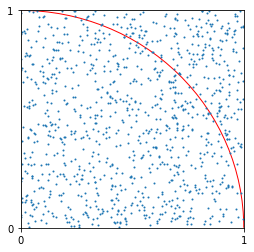

In [41]:
# crude Monte-Carlo
%matplotlib inline
from pdb import set_trace as st
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

fig, ax = plt.subplots(figsize=(4,4))
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.grid()
ax.set_xlim([0,1])
ax.set_ylim([0,1])

a = patches.Arc( (0,0), 2, 2, theta1=0, theta2=90, edgecolor="red")
ax.add_patch(a)

nu_points = 1000
x = np.random.rand(nu_points)
y = np.random.rand(nu_points)
plt.scatter(x, y, s=1)

plt.show()

### サンプリングによる探索 （原始モンテカルロ囲碁）

上記のような乱数によるサンプリングを用いてゲームをプレイさせようという考え方がある。
囲碁、オセロ、3目並べなどのゲームでは、盤面が段々埋まっていくので、ランダムに手を選んでプレイさせてもルール通り終局する。
（囲碁の場合は「目」を残すという制約が必要。）

<img src="playout.png" width=600>

乱数を用いて何らかのスコアを計算することを通常は**simulation**と呼ぶが、
ゲームや機械学習の分野ではこのように1回終局まで手順を進めてみることを **Rollout** や **Playout** と呼ぶ。
この図では、ある局面から3回の Rollout を行い、黒から見て2勝1敗の結果を得た。
勝率 0.66 ということで少し黒が有利なのかも知れない。

<img src="simple_mcgo.png" width=600>

これを元に、全ての候補手についてある程度の回数の Rollout を実行し、勝率最大の手を選ぶという
方法が考えられる。
この方法で、実際に動作する囲碁プログラムを作成することができる。
これを仮に**原始モンテカルロ囲碁**と呼ぶことにする。

> B. Brügmann, "Monte Carlo Go", 1993


## 原始モンテカルロ囲碁を改良する

上で示した原始モンテカルロ囲碁の図では、
全ての候補手から同じ回数だけ Rollout を実行していた。
しかしこれは無駄ではないだろうか。
統計的に見て、明らかに悪い選択肢から Rollout を行う回数を減らして
より良い選択肢に計算資源を集中すれば、少ない Rollout の回数で正確に最善手が求められるはずである。
では、どのような基準でより良い選択肢を選べば良いだろうか。

<img src="better_mcgo.png" width=300>


### 単純に勝率最大の手を選ぶ場合

目的を考えると、勝率が良い選択肢を優遇するべきである。
しかし、これはそれほど簡単では無い。以下の図を見てみよう。

<img src="select_best_move.png" width=600>

例えば3勝2敗の選択肢と2勝3敗の選択肢なら、3勝2敗の方が良さそうだ。
だが良い手を優遇しようとすると Rollout の回数に不均衡が出てくる。
例えば、50勝50敗の選択肢と0勝1敗の選択肢があったとして、どちらを選ぶべきだろうか？
0勝1敗の選択肢は、実際には勝率が0.5より高いのに運が悪く最初の1回の Rollout で負けてしまった可能性がある。
どちらの選択肢を選ぶべきかどうか、自明では無い。

### バンディット問題のアルゴリズムの定義

上記の問題は **Multi-Armed Bandit 問題** の一種として定式化することができる。

<img src="bandit.png" width=400>

スロットマシーンのことを "one-armed bandit" と呼ぶことがある。
ここで出てきた "multi-armed bandit" は空想上の存在で、腕が複数あるスロットマシーンのことを意味する。
（図ではスロットマシーン自体が複数あるように画いている。）
この問題の定義は以下の様になる。

> それぞれの腕は、ある確率分布に従って報酬を返す。手持ちのコインを使ってできるだけ多くの報酬を得よ。

この問題には、今のところ報酬が一番良さそうな腕を引くか、あるいは報酬がまだ不明な腕を引くかどちらを
選ぶべきかというジレンマがある。
これを **exploration-exploitation ジレンマ** と呼ぶ。
（日本語訳は「探査と搾取のジレンマ」「探索と利用のジレンマ」など色々あるので英語を覚えよう。）

Multi-Armed Bandit を略して**バンディット問題**と言われることもある。
これは古くから現代まで研究されている問題であり、
たとえば農作物として何を植えるべきか（報酬は数ヶ月後）、あるいはWeb広告として何を表示すべきか（報酬は数秒後）
など様々な問題をバンディット問題として捕らえることができる。
さらに機械学習（特に強化学習）にも深い関係がある。

### バンディット問題のアルゴリズム

具体的にはどのようなアルゴリズムがあるのか、ここでは2つ紹介しよう。

#### $\epsilon$-greedy 

これは確率 $1-\epsilon$ で期待値が最大の選択肢を選び、
確率 $\epsilon$ で残りの選択肢からランダムに選ぶという方法である。
$\epsilon$は0.1などの定数にすることもあるし、動的に調整することもある。
当然だが、 $\epsilon$ が大きすぎると無駄な exploration を行うが
小さすぎると最善の候補手を見逃す可能性がある。

#### UCB1 (Upper-Confidence Bound)

UCB1は以下の論文で提案された手法の一つである。
$i$番目の腕について、投入されたコインが$s_i$枚で報酬の累積が$w_i$としよう。
また、コインの合計 $t = \Sigma s_i$ とする。
UCB1は、以下の式が最大となる腕を引く方法である。

$ \frac{w_i}{s_i} + C \sqrt{ \frac{2 \ln t}{s_i} }$

ここで、$C$は何らかの定数である。報酬の値域が $[0,1]$ ならば、以下の証明が成立するためには $C=1$ で良い。
実際には$C$は分布の様子を見てもっと小さい値に設定されることが多い。
定数$C$は探索の割合をコントロールするものなので **exploration constant** と呼ぶことがある。

最善の選択肢だけを選び続けた場合に得られる最善の累積報酬と、
ある手法に従って得られる報酬の差の期待値を **累積レグレット (cumulative regret)** と呼ぶ。
UCT1は累積レグレットのオーダーを最小化することが証明されている。
あるいは、コインの総数$t$が無限大に近づいた場合、最善でない腕を引く割合がゼロに近づくという証明がある。

> Auer, Cesa-Bianchi, Fischer, "Finite-time Analysis of the Multiarmed Bandit Problem," Machine Learning, Vol. 47, 2002.

### この手法の強さ

念のため、ここまでの手法に従って囲碁プログラムなどを作るとかなり弱い。
ただ弱いだけではなく、無限に計算時間を費やしても最善手を求めることができない。
Monte-Carlo Tree Search はこの問題を解決する。
次回は、ここで紹介した手法を元に MCTS を実装する。

## 第8回課題

- 8-1. 【なぜ弱い？】 上記の原始モンテカルロ囲碁や、最善手で集中的に Rollout を行う方法はなぜ弱いのか、考察せよ。
- 8-2. 【バンディット問題】 一様分布に基づいて報酬を返す「腕」を何本か用意し、$\epsilon$-greedy か UCB1 （あるいは両方）で腕を選ぶ方法を実装し、
    動作を観察せよ。腕の報酬の分布を近づけてみたり、$\epsilon$ や UCB1 の定数 $C$ を変化させて違いを観察せよ。
- 8-3. 【3目並べRollout】 3目並べについて、適当な局面から playout (rollout) をするプログラムを作成し、適当な回数 playout を実行して報酬を計算せよ。
    報酬としては、手番プレイヤーの勝/負/引き分けに対して、 +1/-1/0 あるいは +1/0/0.5 などと適当に定義せよ。以下のコードを参考にしても良い。
- 8-4. 【原始モンテカルロ3目並べ】 3目並べについて、適当な盤面から、全ての候補手に対して playout を10回行って報酬が最大となる手を選ぶプログラムを作成せよ。
    また、 playout 回数を100回などに増やして最善手を選ぶ確率が上がるかどうか観察せよ。
- 8-5. (発展課題) 【原始モンテカルロ4目並べ】 重力付き4目並べ （Connect Four) について、 8-2, 8-3 と同様に playout を実装し、それを元に報酬が最大となる手を選ぶプログラムを作成せよ。

### 課題の補足

8-1. バンディット問題について。
以下の1行は Jupyter Notebook で Matplotlib ライブラリを使って図を表示するためのものである。
```Python
%matplotlib inline
```
また、numpy.random.random によって $[0,1)$ の一様乱数を生成している。


# 課題1  
Since only the win rate is seen, branches with lower win rates cannot be tested enough, and each node is overly dependent on the first payoff. This leads to extreme cases of Monte-Carlo Tree search results, where some branches are searched all the time, and some branches are searched only once.

# 課題2   


e-greedy
e=0.1
[['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['r', 3], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['r', 1], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['r', 3], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['r', 2], ['g', 0], ['g', 0], ['g', 0], ['g', 0], ['g', 0]]
total_reward:  26


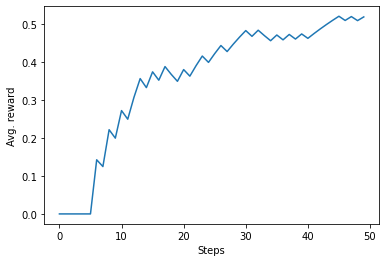

e=0.5
[['g', 0], ['r', 1], ['r', 1], ['r', 2], ['g', 2], ['r', 1], ['r', 0], ['g', 2], ['r', 0], ['g', 2], ['g', 2], ['r', 2], ['g', 2], ['g', 2], ['g', 2], ['r', 0], ['r', 1], ['r', 0], ['g', 2], ['r', 2], ['r', 1], ['g', 2], ['r', 3], ['g', 2], ['g', 2], ['r', 0], ['r', 0], ['r', 0], ['r', 2], ['r', 1], ['r', 2], ['r', 0], ['g', 2], ['r', 2], ['g', 2], ['r', 3], ['r', 3], ['g', 2], ['r', 3], ['g', 2], ['r', 2], ['g', 2], ['g', 2], ['r', 1], ['r', 1], ['r', 0], ['r', 2], ['g', 2], ['r', 3], ['r', 1]]
total_reward:  34


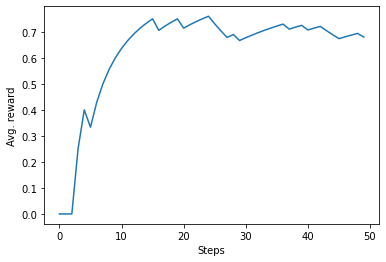

e=0.9
[['r', 2], ['r', 0], ['g', 2], ['r', 0], ['g', 2], ['r', 0], ['r', 3], ['r', 3], ['r', 1], ['r', 3], ['r', 3], ['r', 1], ['r', 2], ['g', 3], ['r', 3], ['r', 0], ['r', 0], ['r', 2], ['r', 2], ['r', 3], ['r', 2], ['r', 0], ['r', 0], ['r', 1], ['r', 3], ['r', 2], ['r', 2], ['r', 0], ['r', 2], ['r', 3], ['r', 3], ['r', 1], ['r', 0], ['r', 2], ['r', 3], ['r', 2], ['r', 3], ['r', 1], ['r', 0], ['r', 3], ['r', 1], ['r', 0], ['g', 3], ['r', 3], ['g', 3], ['r', 1], ['r', 0], ['r', 2], ['r', 0], ['r', 3]]
total_reward:  34


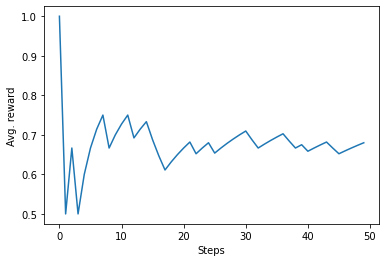

UCB
c=0.1
[['ucb', 0], ['ucb', 1], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2]]
total_reward:  43


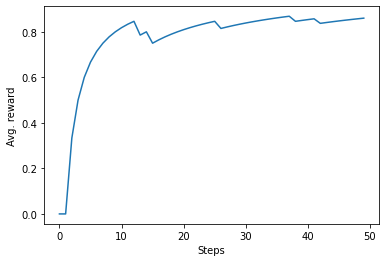

c=0.5
[['ucb', 0], ['ucb', 1], ['ucb', 2], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3], ['ucb', 3]]
total_reward:  42


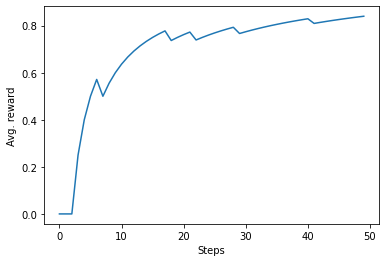

c=1
[['ucb', 0], ['ucb', 1], ['ucb', 1], ['ucb', 1], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2], ['ucb', 2]]
total_reward:  43


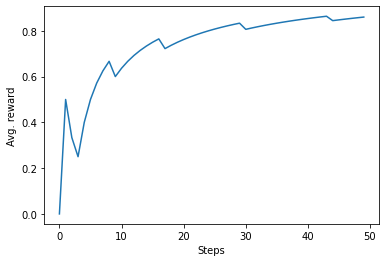

In [44]:
# bandit 問題の参考コード
%matplotlib inline
from pdb import set_trace as st
import numpy as np
import matplotlib.pyplot as plt

class Arm:
    def __init__(self, rate):
        self.rate = rate
        self.coins = 0
        self.reward = 0

    def pull(self):
        self.coins += 1
        if self.rate > np.random.rand():
            self.reward += 1
            return 1
        else:
            self.reward += 0
            return 0

class Game:
    def __init__(self):
        self.nu_arms = 4
        self.arms = []
        self.arms.append(Arm(0.5))
        self.arms.append(Arm(0.1))
        self.arms.append(Arm(0.8))
        self.arms.append(Arm(0.9))
        self.choice = []
        self.choice_times=[1 for i in range(self.nu_arms)]

    def SelectArm_by_egreedy(self,e):
        '''
        ここに Arm を選ぶコードを書け。
        （このコードの例では、返値は最善の Arm の番号としている）
        '''
        reward_li=[i.reward for i in self.arms]
        if np.random.rand() >e:
            self.choice.append(['g',np.argmax(reward_li)])
            return np.argmax(reward_li)
        else:
            r=np.random.randint(0,len(self.arms))
            self.choice.append(['r',r])
            return r
    
    def SelectArm_by_UCB(self,c):
        reward_li=[i.reward for i in self.arms]
        total=sum(self.choice_times)
        bonus=np.sqrt((2*np.log(np.array(total)))/np.array(self.choice_times))
        ucb_reward=np.array(reward_li)+ c*bonus
        self.choice_times[np.argmax(ucb_reward)]+=1
        self.choice.append(['ucb',np.argmax(ucb_reward)])
        return np.argmax(ucb_reward)
        

    def Play(self, steps,e):
        total_reward = 0
        plot_avg_reward = []
        for step in range(steps):
            arm_id = self.SelectArm_by_egreedy(e)
            reward = self.arms[arm_id].pull()
            total_reward += reward
            plot_avg_reward.append(total_reward / (step+1))
        
        print(self.choice)
        print ('total_reward: ',total_reward)
        plt.xlabel('Steps')
        plt.ylabel('Avg. reward')
        plt.plot(plot_avg_reward)
        plt.show()
        
    def play_by_ucb(self,steps,c):
        total_reward = 0
        plot_avg_reward = []
        for step in range(steps):
            arm_id = self.SelectArm_by_UCB(c)
            reward = self.arms[arm_id].pull()
            total_reward += reward
            plot_avg_reward.append(total_reward / (step+1))
        
        print(self.choice)
        print ('total_reward: ',total_reward)
        plt.xlabel('Steps')
        plt.ylabel('Avg. reward')
        plt.plot(plot_avg_reward)
        plt.show()

print('e-greedy')
g = Game()
print('e=0.1')
g.Play(50,0.1)
g = Game()
print('e=0.5')
g.Play(50,0.5)
g = Game()
print('e=0.9')
g.Play(50,0.9)

print('UCB')
g= Game()
print('c=0.1')
g.play_by_ucb(50,0.1)
g = Game()
print('c=0.5')
g.play_by_ucb(50,0.5)
g = Game()
print('c=1')
g.play_by_ucb(50,1)


# 課題3

In [76]:
# tic-tac-toe playout
import copy
import random
import numpy as np


class mcts_node:
    def __init__(self,parent=None,move=None,state=None,player_id=None,game=None):
        self.childnode=[]
        self.move=move
        self.state=state
        self.visit=0
        self.value=0
        self.parent=parent
        self.player_id=player_id
        self.game=game
        if game.is_terminal(state):
            self.untried_node=[]
        else:
            self.untried_node=game.board_blank(state)
        
        
    def select_by_ucb(self):
        reward_li=[]
        for i in self.childnode:
            ucb=(i.value/i.visit)+np.sqrt(2*np.log(self.visit)/i.visit)
            reward_li.append(ucb)
        if self.player_id ==0:
            num=np.argmax(reward_li)
        else:
            num=np.argmin(reward_li)
        return self.childnode[num]
        
    
    def expand(self,move,state):
        child=mcts_node(parent=self,move=move,state=state,player_id=1-self.player_id,game=self.game)
        self.untried_node.remove(move)
        self.childnode.append(child)
        return child
        
        
    def backpropagation(self,reward):
        self.visit+=1
        self.value+=reward
        
        
class TicTacToe:
    def __init__(self):
        self.players = ['X', 'O']
        
    def is_terminal(self, state):
        if self.is_draw(state):
            return True
        elif self.is_win(state,0) or self.is_win(state,1):
            return True
        return False
        
    def is_draw(self, state):
        if self.is_win(state,0) or self.is_win(state,1):
            return False
        for i in state:
            for j in i:
                if j==' ':
                    return False
        return True

    def is_win(self, state, player_id):
        a=self.players[player_id]
        li=[]
        for i in range(3):
            if state[i]==[a,a,a]:
                return True
            for j in range(3):
                if state[i][j]==a:
                    li.append([i,j])
        pat=[[[i,j] for i in [0,1,2]] for j in [0,1,2]] +[[[0,0],[1,1],[2,2]]]+[[[0,2],[1,1],[2,0]]]
        for i in pat:
            x=0
            for j in i:
                if j in li:
                    x+=1
            if x==3:
                return True
        return False
    
    def reward(self,state):
        if self.is_draw(state):
            return 0
        elif self.is_win(state,0):
            return 1
        elif self.is_win(state,1):
            return -1
        
    def make_move(self, state, move, player_id):
        new_state = copy.deepcopy(state)
        x, y = move
        char = self.players[player_id]
        new_state[x][y] = char
        return new_state
    
    def board_blank(self,state):
        blank=[]
        for i in range(3):
            for j in range(3):
                if state[i][j]==' ':
                    blank.append([i,j])
        return blank


def mcts(game,begin_state,iteration):
    mstnode=mcts_node(parent=None,move=None,state=begin_state,player_id=0,game=game)
    
    for i in range(iteration):
        node=mstnode
        state=begin_state
        id=mstnode.player_id

                
        while node.untried_node == [] and node.childnode !=[]:
            node=node.select_by_ucb()
            state=game.make_move(state,node.move,id)
            id=1-id
            

        if node.untried_node != []:
            m=random.choice(node.untried_node)
            state=game.make_move(state,m,id)
            id=1-id
            node=node.expand(m,state)

        while not game.is_terminal(state) and game.board_blank(state) != []:
            state=game.make_move(state,move=random.choice(game.board_blank(state)),player_id=id)
            id=1-id

        while node is not None:
            node.backpropagation(game.reward(state))
            node=node.parent
        
    return mstnode
    

In [77]:
game = TicTacToe()
root_state = [[' ',' ','X'],
              [' ','O',' '],
              ['X',' ','O']]
mst=mcts(game,root_state,10)
print('mst.value:',mst.value/mst.visit)
for i in mst.childnode:
    print(i.state,':',i.value/i.visit)

mst.value: -0.1
[[' ', ' ', 'X'], [' ', 'O', 'X'], ['X', ' ', 'O']] : -1.0
[[' ', ' ', 'X'], [' ', 'O', ' '], ['X', 'X', 'O']] : -0.5
[['X', ' ', 'X'], [' ', 'O', ' '], ['X', ' ', 'O']] : -1.0
[[' ', 'X', 'X'], [' ', 'O', ' '], ['X', ' ', 'O']] : 0.0
[[' ', ' ', 'X'], ['X', 'O', ' '], ['X', ' ', 'O']] : 0.5


In [84]:
game = TicTacToe()
root_state = [['X',' ',' '],
              ['X','O',' '],
              ['O','X','O']]        
mst=mcts(game,root_state,10)
print('mst.value:',mst.value/mst.visit)
for i in mst.childnode:
    print(i.state,':',i.value/i.visit)

mst.value: 0.0
[['X', ' ', 'X'], ['X', 'O', ' '], ['O', 'X', 'O']] : 0.3333333333333333
[['X', ' ', ' '], ['X', 'O', 'X'], ['O', 'X', 'O']] : -0.3333333333333333
[['X', 'X', ' '], ['X', 'O', ' '], ['O', 'X', 'O']] : -1.0


# 課題4

In [85]:
game = TicTacToe()
root_state = [[' ',' ',' '],
              [' ',' ',' '],
              [' ',' ',' ']]        
mst=mcts(game,root_state,10)
print('mst.value:',mst.value/mst.visit)
for i in mst.childnode:
    print(i.state,':',i.value/i.visit)

mst.value: 0.5
[[' ', ' ', ' '], [' ', ' ', 'X'], [' ', ' ', ' ']] : -1.0
[[' ', ' ', ' '], [' ', ' ', ' '], ['X', ' ', ' ']] : 1.0
[[' ', ' ', 'X'], [' ', ' ', ' '], [' ', ' ', ' ']] : 1.0
[[' ', ' ', ' '], [' ', ' ', ' '], [' ', ' ', 'X']] : 1.0
[['X', ' ', ' '], [' ', ' ', ' '], [' ', ' ', ' ']] : -1.0
[[' ', 'X', ' '], [' ', ' ', ' '], [' ', ' ', ' ']] : 1.0
[[' ', ' ', ' '], [' ', ' ', ' '], [' ', 'X', ' ']] : 1.0
[[' ', ' ', ' '], [' ', 'X', ' '], [' ', ' ', ' ']] : 0.0
[[' ', ' ', ' '], ['X', ' ', ' '], [' ', ' ', ' ']] : 1.0


In [86]:
game = TicTacToe()
root_state = [[' ',' ',' '],
              [' ',' ',' '],
              [' ',' ',' ']]        
mst=mcts(game,root_state,100)
print('mst.value:',mst.value/mst.visit)
for i in mst.childnode:
    print(i.state,':',i.value/i.visit)

mst.value: 0.43
[[' ', ' ', ' '], [' ', ' ', ' '], [' ', 'X', ' ']] : 0.14285714285714285
[[' ', ' ', ' '], [' ', ' ', ' '], ['X', ' ', ' ']] : 0.3
[[' ', 'X', ' '], [' ', ' ', ' '], [' ', ' ', ' ']] : 0.125
[[' ', ' ', ' '], [' ', ' ', 'X'], [' ', ' ', ' ']] : 0.45454545454545453
[[' ', ' ', ' '], [' ', ' ', ' '], [' ', ' ', 'X']] : 0.5
[[' ', ' ', 'X'], [' ', ' ', ' '], [' ', ' ', ' ']] : -0.25
[[' ', ' ', ' '], [' ', 'X', ' '], [' ', ' ', ' ']] : 0.6470588235294118
[['X', ' ', ' '], [' ', ' ', ' '], [' ', ' ', ' ']] : 0.5882352941176471
[[' ', ' ', ' '], ['X', ' ', ' '], [' ', ' ', ' ']] : 0.5


# 課題5

In [110]:
import copy
import random
import numpy as np

class ConnectFour:
    def __init__(self):
        # 7x6
        self.players = ['X', 'O']
        
    def is_terminal(self, state):
        if self.is_draw(state):
            return True
        elif self.is_win(state,0) or self.is_win(state,1):
            return True
        return False
        
    def is_draw(self, state):
        if self.is_win(state,0) or self.is_win(state,1):
            return False
        for i in range(7):
            if state[i][0]==' ':
                return False
        return True

    def is_win(self, state, player_id):
        li=[]
        for i in range(7):
            for j in range(6):
                if state[i][j]==self.players[player_id]:
                    li.append([i,j])
        for i in li:
            if [i[0]+1,i[1]] in li and [i[0]+2,i[1]] in li and [i[0]+3,i[1]] in li:
                return True
            if [i[0],i[1]+1] in li and [i[0],i[1]+2] in li and [i[0],i[1]+3] in li:
                return True
            if [i[0]+1,i[1]+1] in li and [i[0]+2,i[1]+2] in li and [i[0]+3,i[1]+3] in li:
                return True
            if [i[0]-1,i[1]+1] in li and [i[0]-2,i[1]+2] in li and [i[0]-3,i[1]+3] in li:
                return True
        return False
    
    def reward(self,state):
        if self.is_draw(state):
            return 0
        elif self.is_win(state,0):
            return 1
        elif self.is_win(state,1):
            return -1
        
    def make_move(self, state, move, player_id):
        new_state = copy.deepcopy(state)
        for i in range(6):
            if state[move][i] != ' ':
                char = self.players[player_id]
                new_state[move][i-1] = char
                return new_state
        char = self.players[player_id]
        new_state[move][5] = char
        return new_state

            
    def board_blank(self,state):
        blank=[]
        for i in range(7):
            if state[i][0]==' ':
                blank.append(i)
        return blank
        

In [112]:
game = ConnectFour()
root_state = [[' ',' ',' ',' ',' ',' '],
              [' ',' ',' ',' ',' ',' '],
              [' ',' ',' ',' ',' ',' '],
              [' ',' ',' ',' ',' ',' '],
              [' ',' ',' ',' ',' ',' '],
              [' ',' ',' ',' ',' ',' '],
              [' ',' ',' ',' ',' ',' ']]        
mst=mcts(game,root_state,100)
print('mst.value:',mst.value/mst.visit)
for i in mst.childnode:
    print(i.state,':',i.value/i.visit)

mst.value: 0.14
[[' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', 'X']] : -1.0
[[' ', ' ', ' ', ' ', ' ', 'X'], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' ']] : -0.1111111111111111
[[' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', 'X'], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' ']] : -1.0
[[' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', 'X'], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' '], [' ', ' ', ' ', ' ', ' ', ' ']] : 0.125
[[' ', ' ', ' ', ' ', ' ', ' '], [' ', '

参考文献
1. "Artificial Intelligence: A Modern Approach, 4th Global ed.", by Stuart Russell and Peter Norvig  
   http://aima.cs.berkeley.edu/index.html
1. "ヒューリスティック探索入門", 陣内 佑  
   https://jinnaiyuu.github.io/pdf/textbook.pdf
1. "ゼロから作るDeep Learning 4 - 強化学習編", 斎藤 康毅, オライリージャパン, 2022.